# Neural Network 

In [30]:
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Input

import os
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np 
import seaborn as sns
import importlib


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold ,cross_val_score

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from src.utils.config import Config
from src.visualization import visualize
from src.data import make_dataset
from src.features import build_features
from src.models import models
from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model


sns.set(
    style='whitegrid',
    font_scale=1.5
)

plt.style.use('ggplot')

In [31]:
labled_data_set,expression_level,labels,true_labels= make_dataset.get_data("original")
labled_data_set_sd,expression_level_sd,labels,true_labels= make_dataset.get_data("standardized")
labels_array= labels["Class"].values


In [32]:
Y_encoded = []
for i in labels_array :
    if i == 'PRAD' : Y_encoded.append(0)
    if i == 'LUAD': Y_encoded.append(1)
    if i == 'BRCA' : Y_encoded.append(2)
    if i == 'KIRC': Y_encoded.append(3)
    if i == 'COAD': Y_encoded.append(4)

Y_bis = to_categorical(Y_encoded)
Y_bis

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

# Feature Extraction 

Since we have a tremendous number of features , we opt for the transformed data we generated from notebook 01 , we will start by the dataset HGV (highly variable genes ) containing only top 5000 with the highest variance with respect to mean .
Then we will develop an autoencoder to learn a compressed representation of the input features for a classification predictive modeling problem. 

In [33]:
HGV,PCA,UMAP,TSNA = make_dataset.get_transformed_data()
data=HGV 
X_train, X_test, y_train, y_test = train_test_split(data, Y_bis, test_size=0.33, random_state=42,stratify=labels_array)

## Autoencoder

In [34]:
importlib.reload(models)
history_encoder=models.encoder(X_train, X_test,factor=10)


Epoch 1/200
34/34 - 2s - loss: 10.9567 - val_loss: 812.3095
Epoch 2/200
34/34 - 1s - loss: 5.1361 - val_loss: 90.0024
Epoch 3/200
34/34 - 1s - loss: 4.6807 - val_loss: 24.4220
Epoch 4/200
34/34 - 1s - loss: 4.4175 - val_loss: 12.3572
Epoch 5/200
34/34 - 1s - loss: 4.5699 - val_loss: 8.0368
Epoch 6/200
34/34 - 1s - loss: 4.2873 - val_loss: 5.1872
Epoch 7/200
34/34 - 1s - loss: 4.1397 - val_loss: 4.0982
Epoch 8/200
34/34 - 1s - loss: 3.9706 - val_loss: 3.9856
Epoch 9/200
34/34 - 1s - loss: 3.9885 - val_loss: 3.9106
Epoch 10/200
34/34 - 1s - loss: 3.9210 - val_loss: 4.0736
Epoch 11/200
34/34 - 1s - loss: 3.8722 - val_loss: 4.1984
Epoch 12/200
34/34 - 1s - loss: 3.8999 - val_loss: 4.0619
Epoch 13/200
34/34 - 1s - loss: 3.8612 - val_loss: 4.1407
Epoch 14/200
34/34 - 1s - loss: 3.7099 - val_loss: 3.9376
Epoch 15/200
34/34 - 1s - loss: 3.7766 - val_loss: 3.7794
Epoch 16/200
34/34 - 1s - loss: 3.8381 - val_loss: 4.0856
Epoch 17/200
34/34 - 1s - loss: 3.6823 - val_loss: 4.0476
Epoch 18/200
34/3

# Define The model 

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_27 (Dense)             (None, 80)                8080      
_________________________________________________________________
dense_28 (Dense)             (None, 30)                2430      
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 155       
Total params: 10,665
Trainable params: 10,665
Non-trainable params: 0
_________________________________________________________________


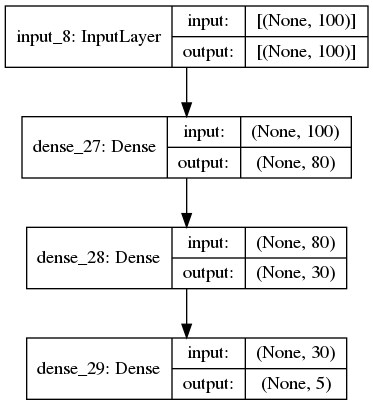

In [35]:
importlib.reload(models)
DNN_model=models.init_model()
plot_model(DNN_model, to_file=Config.project_dir /'reports/figures/model_DNN_plot.png', show_shapes=True, show_layer_names=True)


# ENCODE data 
Using the encoder we defined earlier and saved in  'encoder.h5' file 

In [36]:
from tensorflow.keras.models import load_model

# load the model from file
encoder = load_model(Config.project_dir/ 'models/encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
model = DNN_model

# Train the model 

In [37]:
# fit the model on the training set
history=model.fit(X_train_encode,y_train,validation_split=0.33, batch_size=32, epochs=250, verbose=1)
print(history.history.keys())


Epoch 1/250
12/12 [==============================] - 0s 14ms/step - loss: 0.6868 - accuracy: 0.1645 - val_loss: 0.6796 - val_accuracy: 0.2203
Epoch 2/250
12/12 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.2032 - val_loss: 0.6703 - val_accuracy: 0.3051
Epoch 3/250
12/12 [==============================] - 0s 4ms/step - loss: 0.6680 - accuracy: 0.2710 - val_loss: 0.6595 - val_accuracy: 0.3729
Epoch 4/250
12/12 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.3007 - val_loss: 0.6467 - val_accuracy: 0.4237
Epoch 5/250
12/12 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.3390 - val_loss: 0.6312 - val_accuracy: 0.4181
Epoch 6/250
12/12 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.3594 - val_loss: 0.6124 - val_accuracy: 0.4124
Epoch 7/250
12/12 [==============================] - 0s 4ms/step - loss: 0.6056 - accuracy: 0.3929 - val_loss: 0.5896 - val_accuracy: 0.4011
Epoch 8/250


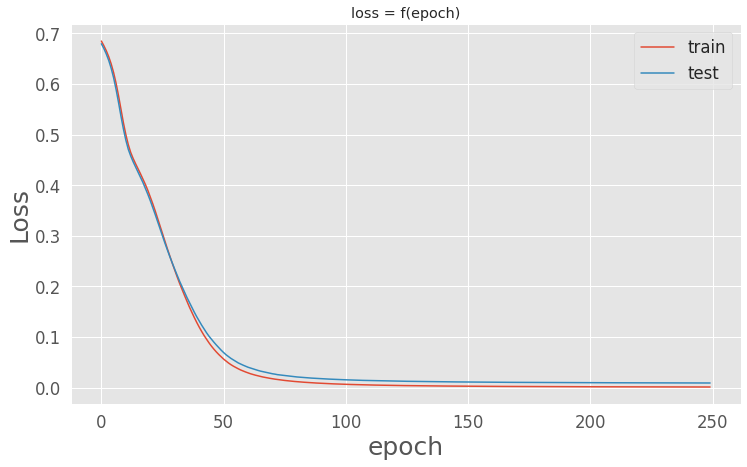

In [38]:
# plot loss
plt.figure(figsize=(12,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.title("loss = f(epoch)")
plt.xlabel("epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)
plt.legend()
plt.show()

In [39]:
Z = model.predict(X_test_encode)
prediction = np.argmax(Z, axis = 1)
y_test_not_bis = np.argmax(y_test, axis = 1) # test labels encoded [0,1,2,3,4] = [different cancer type]

In [40]:
print(accuracy_score(y_test_not_bis, prediction))


0.9962264150943396


In [41]:
print(pd.crosstab(y_test_not_bis,prediction))


col_0   0   1   2   3   4
row_0                    
0      45   0   0   0   0
1       0  46   1   0   0
2       0   0  99   0   0
3       0   0   0  48   0
4       0   0   0   0  26


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_33 (Dense)             (None, 80)                8080      
_________________________________________________________________
dense_34 (Dense)             (None, 30)                2430      
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 155       
Total params: 10,665
Trainable params: 10,665
Non-trainable params: 0
_________________________________________________________________


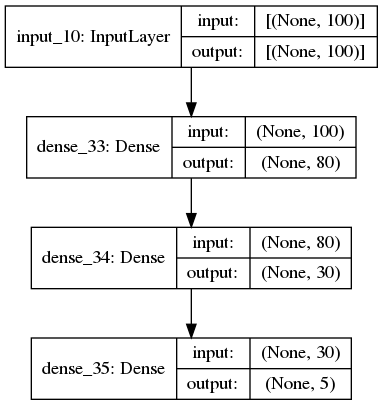

In [48]:
importlib.reload(models)

model = models.init_model()
plot_model(model, to_file=Config.project_dir /'reports/figures/generated/model_DNN_plot__.png', show_shapes=True, show_layer_names=True)


In [49]:
from tensorflow.keras.models import load_model

# load the model from file
encoder = load_model(Config.project_dir/ 'models/encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model


In [50]:
# fit the model on the training set
history=model.fit(X_train_encode,y_train,validation_split=0.33, batch_size=32, epochs=250, verbose=0)

In [51]:
Z = model.predict(X_test_encode)
prediction = np.argmax(Z, axis = 1)
y_test_not_bis = np.argmax(y_test, axis = 1) # test labels encoded [0,1,2,3,4] = [different cancer type]

In [52]:
print(accuracy_score(y_test_not_bis, prediction))

0.9962264150943396


In [53]:
print(pd.crosstab(y_test_not_bis,prediction))

col_0   0   1   2   3   4
row_0                    
0      45   0   0   0   0
1       0  46   1   0   0
2       0   0  99   0   0
3       0   0   0  48   0
4       0   0   0   0  26
